In [3]:
from pathlib import Path
import hashlib
import re
import sqlite3
import pandas as pd
from datetime import datetime
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# --------------------
# Paths & Setup
# --------------------
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "Data"
DATA_DIR.mkdir(exist_ok=True)

DB_PATH = DATA_DIR / "ng_sentiment.db"
CSV_OUT = DATA_DIR / "NG_Sentiment_Analysis.csv"



# --------------------
# Load FinBERT
# --------------------
MODEL_NAME = "ProsusAI/finbert"
print("Loading FinBERT model, this may take a moment...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=-1)

# --------------------
# DB Setup
# --------------------
def init_db():
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()

    cur.execute("""
    CREATE TABLE IF NOT EXISTS articles (
        id TEXT PRIMARY KEY,
        date TEXT,
        filename TEXT,
        collected_at TEXT,
        raw_text TEXT
    )
    """)

    cur.execute("""
    CREATE TABLE IF NOT EXISTS sentences (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        article_id TEXT,
        sentence TEXT,
        label TEXT,
        score REAL,
        annotated_at TEXT,
        FOREIGN KEY(article_id) REFERENCES articles(id)
    )
    """)

    cur.execute("""
    CREATE TABLE IF NOT EXISTS article_sentiment (
        article_id TEXT PRIMARY KEY,
        overall_sentiment TEXT,
        sentiment_score REAL,
        aggregated_at TEXT,
        FOREIGN KEY(article_id) REFERENCES articles(id)
    )
    """)

    conn.commit()
    conn.close()

# --------------------
# Utils
# --------------------
def clean_text(text):
    t = re.sub(r'\r\n', '\n', text)
    t = re.sub(r'\n\s+\n', '\n\n', t)
    t = re.sub(r'\s+\n', '\n', t)
    t = re.sub(r'\n{3,}', '\n\n', t)
    return t.strip()

def split_sentences(text):
    sents = sent_tokenize(text)
    return [s.strip() for s in sents if len(s.strip()) > 5]

def predict_batch(sentences, batch_size=16):
    results = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        out = finbert(batch, truncation=True)
        results.extend(out)
    return results

def article_id(date, text):
    return hashlib.sha256((date + text).encode("utf-8")).hexdigest()

# --------------------
# Insertions
# --------------------
def insert_article(article_id_val, date, filename, text):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("""
        INSERT OR IGNORE INTO articles (id, date, filename, collected_at, raw_text)
        VALUES (?, ?, ?, ?, ?)
    """, (article_id_val, date, filename, datetime.utcnow().isoformat(), text))
    conn.commit()
    conn.close()

def insert_sentences(article_id_val, sentences_with_preds):
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    for s, pred in sentences_with_preds:
        cur.execute("""
            INSERT INTO sentences (article_id, sentence, label, score, annotated_at)
            VALUES (?, ?, ?, ?, ?)
        """, (article_id_val, s, pred['label'], float(pred['score']), datetime.utcnow().isoformat()))
    conn.commit()
    conn.close()

def insert_article_sentiment(article_id_val, date, predictions):
    """
    Aggregate sentence-level predictions for a single article/date
    and store the result in the database.
    """
        
    sentiment_scores = {'positive': 0, 'negative': 0, 'neutral': 0}
    for pred in predictions:
        sentiment_scores[pred['label']] += pred['score']

    total_score = sum(sentiment_scores.values())
    if total_score == 0:
        overall_sentiment, sentiment_score = "neutral", 0.0
    else:
        positive_avg = sentiment_scores['positive'] / total_score
        negative_avg = sentiment_scores['negative'] / total_score
        neutral_avg = sentiment_scores['neutral'] / total_score

        if positive_avg > negative_avg and positive_avg > neutral_avg:
            overall_sentiment, sentiment_score = "positive", positive_avg
        elif negative_avg > positive_avg and negative_avg > neutral_avg:
            overall_sentiment, sentiment_score = "negative", negative_avg
        else:
            overall_sentiment, sentiment_score = "neutral", neutral_avg

    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("""
        INSERT OR REPLACE INTO article_sentiment (article_id, overall_sentiment, sentiment_score, aggregated_at)
        VALUES (?, ?, ?, ?)
    """, (article_id_val, overall_sentiment, sentiment_score, datetime.utcnow().isoformat()))
    conn.commit()
    conn.close()
    
    print(f"[{date}] → {overall_sentiment} ({sentiment_score:.3f})")
    return overall_sentiment, sentiment_score

# --------------------
# Export
# --------------------
def export_latest_csv():
    conn = sqlite3.connect(DB_PATH)
    df = pd.read_sql_query("""
    SELECT a.date, a.filename, s.sentence, s.label, s.score, ag.overall_sentiment, ag.sentiment_score
    FROM sentences s
    JOIN articles a ON a.id = s.article_id
    JOIN article_sentiment ag ON ag.article_id = a.id
    ORDER BY a.date ASC
    """, conn)
    conn.close()
    df.to_csv(CSV_OUT, index=False)
    print(f"Exported CSV to {CSV_OUT}")
    return df

# --------------------
# Main Run
# --------------------
if __name__ == "__main__":
    init_db()

    folder = Path("Natural Gas")
    for file in folder.glob("*.txt"):
        date = file.stem  # e.g. 2025-06-05
        text = file.read_text(encoding="utf-8")
        cleaned = clean_text(text)
        if not cleaned.strip():
            continue

        aid = article_id(date, cleaned)
        insert_article(aid, date, file.name, cleaned)

        sentences = split_sentences(cleaned)
        if not sentences:
            continue

        preds = predict_batch(sentences)
        insert_sentences(aid, list(zip(sentences, preds)))
        insert_article_sentiment(aid, date, preds)

    df = export_latest_csv()
    print(df.head())

Loading FinBERT model, this may take a moment...
[2025-06-05] → negative (0.506)
[2025-06-12] → positive (0.469)
[2025-06-26] → positive (0.461)
[2025-07-10] → negative (0.525)
[2025-07-17] → positive (0.599)
[2025-07-24] → negative (0.618)
[2025-07-31] → negative (0.417)
[2025-08-07] → negative (0.579)
[2025-08-14] → positive (0.489)
[2025-08-21] → negative (0.525)
[2025-08-28] → negative (0.525)
[2025-09-04] → negative (0.519)
[2025-09-11] → negative (0.544)
[2025-09-18] → positive (0.527)
[2025-09-25] → negative (0.458)
Exported CSV to C:\Users\shash\Data\NG_Sentiment_Analysis.csv
         date        filename  \
0  2025-06-05  2025-06-05.txt   
1  2025-06-05  2025-06-05.txt   
2  2025-06-05  2025-06-05.txt   
3  2025-06-05  2025-06-05.txt   
4  2025-06-05  2025-06-05.txt   

                                            sentence     label     score  \
0             Market Context and Price Movements\nA.   neutral  0.900183   
1  Domestic Spot Prices\nNatural gas spot prices ...  nega

In [4]:
df.tail()


,date,filename,sentence,label,score,overall_sentiment,sentiment_score
2545,2025-09-25,2025-09-25.txt,LNG Export Shift: Total LNG pipeline receipts ...,positive,0.884715,negative,0.458314
2546,2025-09-25,2025-09-25.txt,"However, the distribution shifted drastically ...",negative,0.932511,negative,0.458314
2547,2025-09-25,2025-09-25.txt,This maintenance caused deliveries outside the...,negative,0.971439,negative,0.458314
2548,2025-09-25,2025-09-25.txt,Rig Count and Supply: The natural gas rig coun...,positive,0.675039,negative,0.458314
2549,2025-09-25,2025-09-25.txt,Total supply decreased slightly due to a small...,negative,0.954752,negative,0.458314


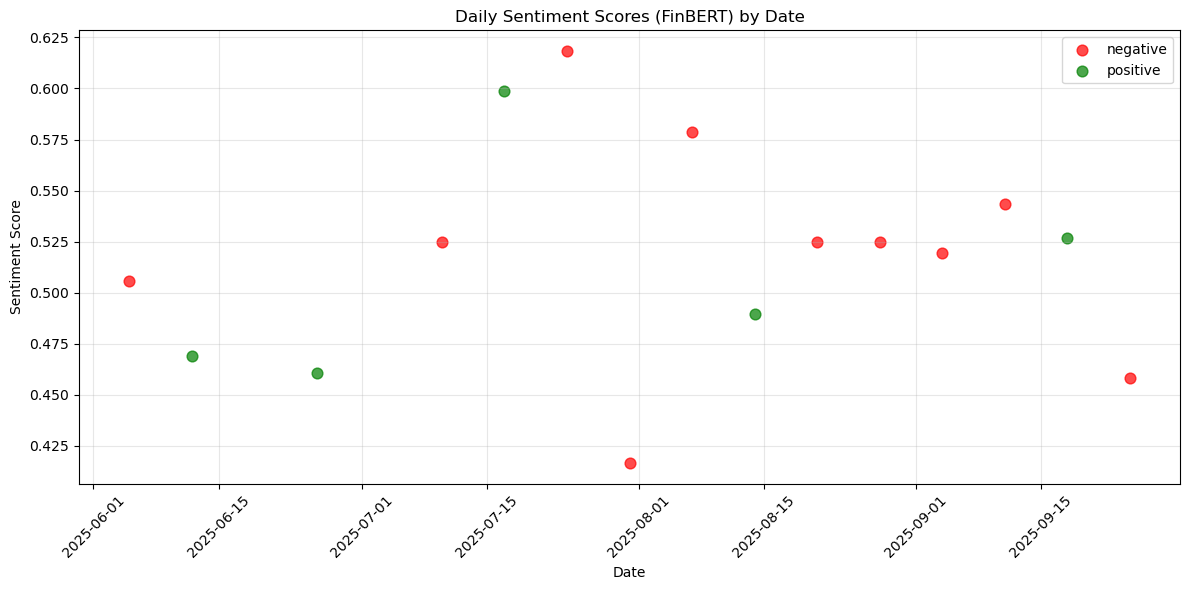

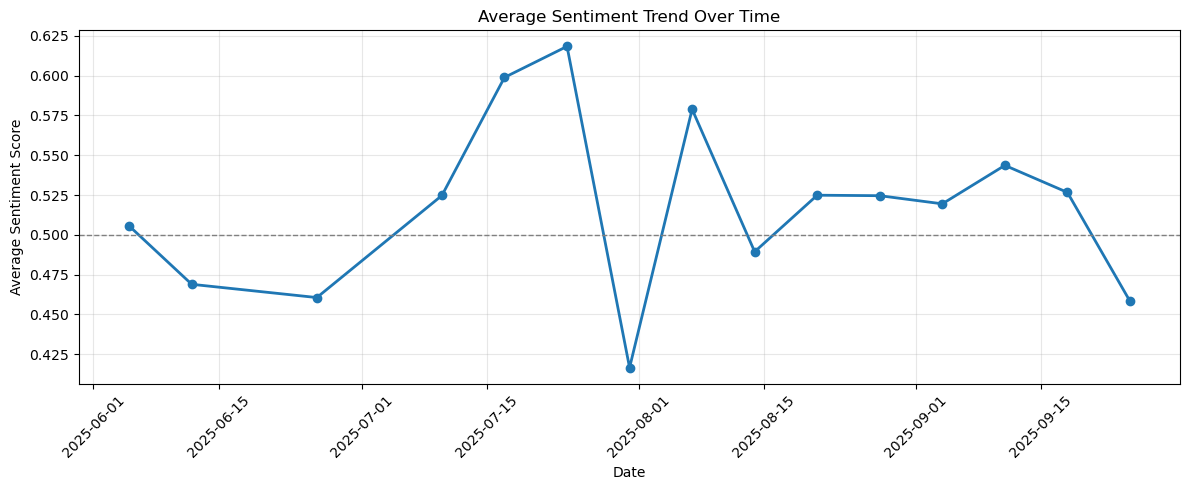

In [8]:
# --------------------
# Visualization
# --------------------
import matplotlib.pyplot as plt

# Reconnect to DB and load sentiment results
conn = sqlite3.connect(DB_PATH)
sent_df = pd.read_sql_query("""
SELECT a.date, ag.overall_sentiment, ag.sentiment_score
FROM article_sentiment ag
JOIN articles a ON a.id = ag.article_id
ORDER BY a.date ASC
""", conn, parse_dates=["date"])
conn.close()

if sent_df.empty:
    print("No sentiment data to plot.")
else:
    # 1️⃣ Scatter plot (color by overall sentiment)
    plt.figure(figsize=(12, 6))
    colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
    for sentiment, group in sent_df.groupby('overall_sentiment'):
        plt.scatter(group['date'], group['sentiment_score'],
                    color=colors.get(sentiment, 'black'),
                    label=sentiment, alpha=0.7, s=60)
    plt.title("Daily Sentiment Scores (FinBERT) by Date")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    # 2️⃣ Line chart of average sentiment per day (numerical trend)
    daily_trend = sent_df.groupby('date')['sentiment_score'].mean().reset_index()

    plt.figure(figsize=(12, 5))
    plt.plot(daily_trend['date'], daily_trend['sentiment_score'],
             marker='o', linestyle='-', linewidth=2)
    plt.title("Average Sentiment Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)  # neutral line
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

      date  sentiment_score
2025-06-08         0.505549
2025-06-15         0.468912
2025-06-22              NaN
2025-06-29         0.460587
2025-07-06              NaN
2025-07-13         0.524733
2025-07-20         0.598893
2025-07-27         0.618385
2025-08-03         0.416542
2025-08-10         0.578895
2025-08-17         0.489378
2025-08-24         0.524892
2025-08-31         0.524586
2025-09-07         0.519469
2025-09-14         0.543640
2025-09-21         0.526661
2025-09-28         0.458314
